In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner
from os import path
from os.path import join
import h5py
from ruamel.yaml import YAML

from matplotlib import ticker

import hickle
from os.path import join

from fit3bf import setup_rc_params
from fit3bf.observables import from_hdf5
from fit3bf.graphs import plot_true_vs_approx, setup_rc_params
from fit3bf import param_names_chiral, nnlo_sat_lecs
from fit3bf.constants import param_names_tex_map
from fit3bf.constants import obs_names_tex_map
from fit3bf.utils import lhsnorm, adjust
from fit3bf.graphs import plot_gaussian_from_params
from fit3bf.graphs import plot_true_vs_approx
from fit3bf.graphs import confidence_ellipse, confidence_ellipse_mean_cov, plot_gaussian_approximation, plot_student_t_approximation
from fit3bf.graphs import confidence_ellipse_student_t_from_params, plot_student_t_from_params, optimize_mv_student_t

In [2]:
import pyDOE

In [3]:
setup_rc_params(constrained_layout=False)

# User Input

Set the directory that contains the emulators trained with both NN and 3N LECs.

In [4]:
evc_directory = '../scripts/output/NNLO_450/3a52d8f630f20df7a76019814a7ca86e'
nn_lecs_mean_file = "../scripts/parameters/nnlo_450_nn_lecs.yaml"
nn_lecs_cov_file = "../scripts/nn_lecs_cov.npy"

# This assumes that all the NN LECs come first, then the 3N LECs come after in the emulator
nn_lec_names = [
    "Ct_1S0np",
    "Ct_1S0nn",
    "Ct_1S0pp",
    "Ct_3S1",
    "C_1S0",
    "C_3P0",
    "C_1P1",
    "C_3P1",
    "C_3S1",
    "C_3S1-3D1",
    "C_3P2",
]
tbf_lec_names = ['c_D', 'c_E']
all_lec_names = nn_lec_names + tbf_lec_names

n_nn_lecs = len(nn_lec_names)
n_all_lecs = len(all_lec_names)
n_tbf_lecs = len(tbf_lec_names)

Load the mean vector and covariance matrix for the NN LECs.

In [5]:
yaml = YAML(typ="safe")
with open(nn_lecs_mean_file, "r") as input_file:
    post_param_map = yaml.load(input_file)
    loc_post_lecs = np.array(
        [post_param_map[name] for name in nn_lec_names]
    )
cov_post_lecs = np.load(nn_lecs_cov_file, allow_pickle=False)

Load the emulators, extract the LECs used when training the emulators.

In [6]:
H3 = from_hdf5(join(evc_directory, 'H3.h5'))
He3 = from_hdf5(join(evc_directory, 'He3.h5'))
He4 = from_hdf5(join(evc_directory, 'He4.h5'))

H3_halflife = from_hdf5(join(evc_directory, 'H3-halflife.h5'))
He4_radius = from_hdf5(join(evc_directory, 'He4-radius.h5'))

p_train = H3.p_train
p_train_nn = p_train[:, :n_nn_lecs]
p_train_tbf = p_train[:, n_nn_lecs:]

Get the LaTeX names of the LECs

In [7]:
nn_lecs_names_tex = [param_names_tex_map[name] for name in nn_lec_names]
all_lecs_names_tex = [param_names_tex_map[name] for name in all_lec_names]
tbf_lecs_names_tex = [param_names_tex_map[name] for name in tbf_lec_names]

In [8]:
loc_tbf_lecs = np.array([0, 0])
cov_tbf_lecs = 5**2 * np.eye(2)
loc_all_lecs = np.append(loc_post_lecs, loc_tbf_lecs)
loc_all_lecs
cov_all_lecs = np.block([
    [cov_post_lecs, np.zeros((cov_post_lecs.shape[-1], 2))],
    [np.zeros((2, cov_post_lecs.shape[0])), cov_tbf_lecs]
])

In [9]:
loc_all_lecs

array([-0.15263259, -0.15231072, -0.1519951 , -0.17844706,  2.39169697,
        0.99935281,  0.22117731, -0.97352638,  0.55144146,  0.43702288,
       -0.69226719,  0.        ,  0.        ])

In [10]:
cov_all_lecs[9:, 9:]

array([[ 3.72e-05, -6.49e-07,  0.00e+00,  0.00e+00],
       [-6.49e-07,  5.58e-07,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  2.50e+01,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  2.50e+01]])

In [11]:
cov_df = pd.DataFrame(cov_post_lecs, index=nn_lecs_names_tex, columns=nn_lecs_names_tex)
cov_df

,$\tilde C^{np}_{1S0}$,$\tilde C^{nn}_{1S0}$,$\tilde C^{pp}_{1S0}$,$\tilde C_{3S1}$,$C_{1S0}$,$C_{3P0}$,$C_{1P1}$,$C_{3P1}$,$C_{3S1}$,$C_{3S1}^{3D1}$,$C_{3P2}$
$\tilde C^{np}_{1S0}$,6.220000e-09,5.910000e-09,5.490000e-09,-6.070000e-09,-1.390000e-07,8.230000e-08,-7.080000e-08,9.600000e-08,6.010000e-08,3.050000e-08,-6.130000e-09
$\tilde C^{nn}_{1S0}$,5.910000e-09,9.030000e-08,5.300000e-09,-6.430000e-09,-1.340000e-07,7.990000e-08,-6.790000e-08,9.300000e-08,6.100000e-08,2.920000e-08,-5.880000e-09
$\tilde C^{pp}_{1S0}$,5.490000e-09,5.300000e-09,4.950000e-09,-5.960000e-09,-1.240000e-07,7.410000e-08,-6.300000e-08,8.620000e-08,5.650000e-08,2.700000e-08,-5.420000e-09
$\tilde C_{3S1}$,-6.070000e-09,-6.430000e-09,-5.960000e-09,5.780000e-07,1.510000e-07,-5.990000e-07,-2.110000e-06,-3.680000e-07,-3.900000e-06,-4.400000e-06,3.930000e-08
$C_{1S0}$,-1.390000e-07,-1.340000e-07,-1.240000e-07,1.510000e-07,3.140000e-06,-1.870000e-06,1.590000e-06,-2.180000e-06,-1.430000e-06,-6.850000e-07,1.380000e-07
$C_{3P0}$,8.230000e-08,7.990000e-08,7.410000e-08,-5.990000e-07,-1.870000e-06,1.940000e-05,-1.310000e-06,3.540000e-06,5.420000e-06,3.050000e-06,-3.680000e-08
$C_{1P1}$,-7.080000e-08,-6.790000e-08,-6.300000e-08,-2.110000e-06,1.590000e-06,-1.310000e-06,9.320000e-05,4.160000e-07,1.360000e-05,1.740000e-05,-1.640000e-07
$C_{3P1}$,9.600000e-08,9.300000e-08,8.620000e-08,-3.680000e-07,-2.180000e-06,3.540000e-06,4.160000e-07,1.280000e-05,4.960000e-06,-4.020000e-08,1.610000e-07
$C_{3S1}$,6.010000e-08,6.100000e-08,5.650000e-08,-3.900000e-06,-1.430000e-06,5.420000e-06,1.360000e-05,4.960000e-06,2.790000e-05,2.840000e-05,1.010000e-08
$C_{3S1}^{3D1}$,3.050000e-08,2.920000e-08,2.700000e-08,-4.400000e-06,-6.850000e-07,3.050000e-06,1.740000e-05,-4.020000e-08,2.840000e-05,3.720000e-05,-6.490000e-07


In [12]:
print(cov_df.to_latex(
#     float_format="${:0.3g}$".format,
    float_format="{:0.3g}".format,
    escape=False,
#     header=[f"{{{col}}}" for col in cov_df.columns]
))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  $\tilde C^{np}_{1S0}$ &  $\tilde C^{nn}_{1S0}$ &  $\tilde C^{pp}_{1S0}$ &  $\tilde C_{3S1}$ &  $C_{1S0}$ &  $C_{3P0}$ &  $C_{1P1}$ &  $C_{3P1}$ &  $C_{3S1}$ &  $C_{3S1}^{3D1}$ &  $C_{3P2}$ \\
\midrule
$\tilde C^{np}_{1S0}$ &               6.22e-09 &               5.91e-09 &               5.49e-09 &         -6.07e-09 &  -1.39e-07 &   8.23e-08 &  -7.08e-08 &    9.6e-08 &   6.01e-08 &         3.05e-08 &  -6.13e-09 \\
$\tilde C^{nn}_{1S0}$ &               5.91e-09 &               9.03e-08 &                5.3e-09 &         -6.43e-09 &  -1.34e-07 &   7.99e-08 &  -6.79e-08 &    9.3e-08 &    6.1e-08 &         2.92e-08 &  -5.88e-09 \\
$\tilde C^{pp}_{1S0}$ &               5.49e-09 &                5.3e-09 &               4.95e-09 &         -5.96e-09 &  -1.24e-07 &   7.41e-08 &   -6.3e-08 &   8.62e-08 &   5.65e-08 &          2.7e-08 &  -5.42e-09 \\
$\tilde C_{3S1}$      &              -6.07e-09 &              -6.43e-09 &              -5.96e-09 &     

In [13]:
def plot_samples(p, mean, cov, bins=5, names=None, title=None, axes=None, put_stdv_in_titles=False, show_stdv_ticks=False, mean_fmt='1.2f', title_newline=True):
    nn = p.shape[-1]
    if axes is None:
        fig, axes = plt.subplots(
            nn, nn,
            figsize=(3.4, 3.4),
            sharex=False, sharey=False,
            constrained_layout=False,
        )
        top = 0.98
        if title is not None:
            top = 0.95
        fig.subplots_adjust(
            left=0.11, bottom=0.08, right=0.98, top=top, wspace=0.1, hspace=0.1
        )
    ax_range = []
    for i, x in enumerate(p.T):
        min_dist = mean[i]-2.5*np.sqrt(cov[i,i])
        max_dist = mean[i]+2.5*np.sqrt(cov[i,i])
        ax_rng_i = [x.min() if x.min() < min_dist else min_dist, x.max() if x.max() > max_dist else max_dist]
        ax_range.append(ax_rng_i)
    prior_color = 'C2'
    for (i, j), ax in np.ndenumerate(axes):
        ax.set_xlim(ax_range[j])
        if i >= j:
            ax.set_axis_on()
            if j == 0 and names is not None:
                ax.set_ylabel(names[i], rotation=0, ha='right', va='center', fontdict={'size': 9})
            if i == nn-1 and names is not None:
                ax.set_xlabel(
                    names[j], rotation=35, ha='center', va='top',
                    fontdict={'size': 9}, labelpad=1
                )

            if i == j:
                plot_gaussian_from_params(
                    p[:, i],
                    mean[i], np.sqrt(cov[i, i]),
                    ax=ax, color=prior_color, zorder=-1, lw=1,
                )
                y_hist, _, _ = ax.hist(
                    p[:, i], bins=bins, density=True,
                    color='k', histtype='step',
                )
                if put_stdv_in_titles:
                    ax.set_title(
#                         fr"${{{mean[i]:1.2f}}}\pm\\${np.sqrt(cov[i,i]):1.1g}",
                        fr"${{{mean[i]:{mean_fmt}}}}\pm$"
                        + ("\n" if title_newline else "") +
                        fr"{np.sqrt(cov[i,i]):1.1g}",
                        loc='left', ha='left', fontdict={'size': 6},
                        multialignment="left",
                    )
#                 ax.set_ylim(None, 1.25*y_hist.max())
            if i != j:
                ax.set_ylim(ax_range[i])
                for stdv in [1, 2]:
                    pass
                    confidence_ellipse_mean_cov(
                        mean[[j, i]], cov[np.array([j, i])[:, None], [j, i]],
                        ax, n_std=stdv, facecolor=prior_color, zorder=-1
                    )
                ax.plot(p[:, j], p[:, i], ls='', c='k', marker='o', markersize=0.5, fillstyle='full', alpha=1)
        else:
            ax.set_axis_off()
        if show_stdv_ticks:
            mu_i = mean[i]
            mu_j = mean[j]
            stdv_i = np.sqrt(cov[i, i])
            stdv_j = np.sqrt(cov[j, j])
            if i == nn - 1:
                ax.set_xticks([mu_j-show_stdv_ticks*stdv_j, mu_j+show_stdv_ticks*stdv_j])
                ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
                ax.tick_params(axis='x', rotation=30)
            else:
                ax.set_xticks([])
            if j == 0 and i != 0:
                ax.set_yticks([mu_i-show_stdv_ticks*stdv_i, mu_i+show_stdv_ticks*stdv_i])
                ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
            else:
                ax.set_yticks([])
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    if title is not None:
        fig.suptitle(title)
    return axes

In [14]:
plt.rcParams['savefig.facecolor'] = 'white'

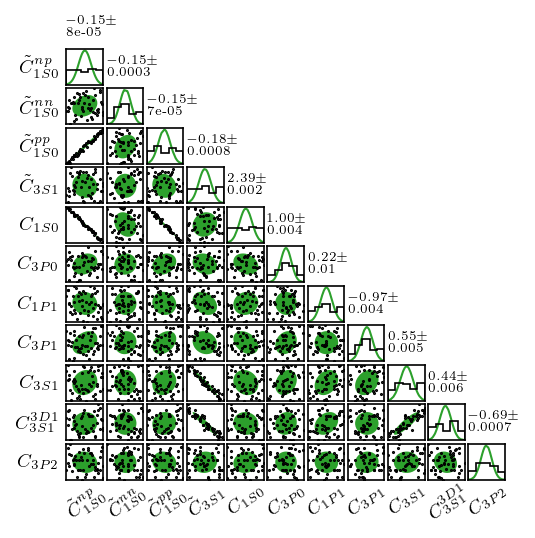

In [15]:
axes = plot_samples(
    p_train_nn, loc_post_lecs, cov_post_lecs,
    names=nn_lecs_names_tex,
#     title='EC Training Points',
    put_stdv_in_titles=True
);
# plot_samples(
#     p_train_tbf, loc_tbf_lecs, cov_tbf_lecs,
#     names=tbf_lecs_names_tex, axes=axes[1:3, -3:-1],
#     put_stdv_in_titles=True
# );
fig = plt.gcf()
fig.subplots_adjust(
    left=0.11, bottom=0.08, right=0.97, top=0.925, wspace=0.1, hspace=0.1
)
fig.savefig('nn_training_pts_with_stdv_titles.png', dpi=800)

In [16]:
def plot_residuals(y_true, y_approx, std=None, text=None, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.4, 3.4))
    ax.errorbar(
            np.arange(len(y_true)), (y_true - y_approx),
            yerr=std, marker='o', ls='', **kwargs
        )
    ax.axhline(0, 0, 1, c='k', lw=1, zorder=-1)
    if text is not None:
        ax.text(
            0.07,
            0.07,
            text,
            ha="left",
            va="bottom",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round", facecolor="w"),
        )
    return ax

In [17]:
expt_map = {
    "H3": -8.482,
    "He4": -28.296,
    "He4-radius": 1.4552,
    "H3-halflife": 1129.6
}

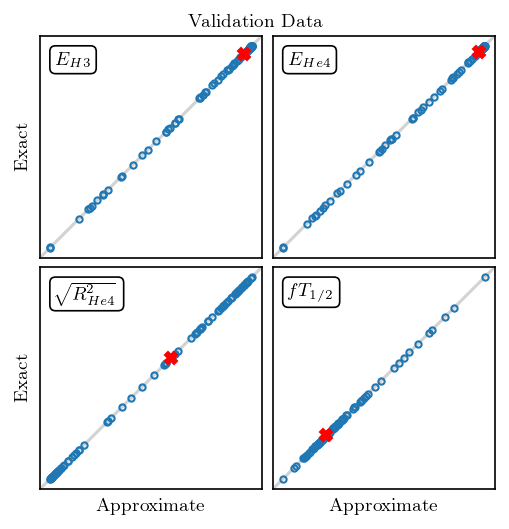

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4))
marker_size = 3
fill_style = 'none'
plot_true_vs_approx(
    H3.E_valid_true, H3.E_valid_approx, text=r'$E_{H3}$',
    expt=expt_map["H3"], ax=axes[0, 0],
    markersize=marker_size, fillstyle=fill_style,
)
plot_true_vs_approx(
    He4.E_valid_true, He4.E_valid_approx, text=r'$E_{He4}$',
    expt=expt_map["He4"], ax=axes[0, 1],
    markersize=marker_size, fillstyle=fill_style,
)
plot_true_vs_approx(
    He4_radius.ev_valid_true, He4_radius.ev_valid_approx,
    text=r'$\sqrt{R^2_{He4}}$', expt=expt_map["He4-radius"], ax=axes[1, 0],
    markersize=marker_size, fillstyle=fill_style,
)
plot_true_vs_approx(
    H3_halflife.ev_valid_true, H3_halflife.ev_valid_approx,
    text=r'$fT_{1/2}$', expt=expt_map["H3-halflife"], ax=axes[1, 1],
    markersize=marker_size, fillstyle=fill_style,
)
for (i, j), ax in np.ndenumerate(axes):
    if j != 0:
        ax.set_ylabel(None)
    if i == 0:
        ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
fig.suptitle('Validation Data', y=0.98)
fig.tight_layout(h_pad=0.5, w_pad=-1, pad=0, rect=[0, 0, 1, 0.97])
fig.savefig('validation_true_vs_approx.pdf')

In [19]:
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

It would be nice to put the units with the scientific notation above the charts. By subclassing `ScalarFormatter` we can make this possible.

In [20]:
class ScalarFormatterWithUnits(ScalarFormatter):
    def __init__(self, useOffset=None, useMathText=None, useLocale=None, units=None):
        self._units = units
        super().__init__(useOffset=useOffset, useMathText=useMathText, useLocale=useLocale)
        
    
    def format_data_short(self, value):
        out = super().format_data_short(value)
        if self._units is not None:
            return out + fr"\,[\textup{{{self._units}}}]"
        else:
            return out
    
    def format_data(self, value):
        out = super().format_data(value)
        if self._units is not None:
            return out + fr"\,[\textup{{{self._units}}}]"
        else:
            return out

In [21]:
obs_units = {
    "H3": "MeV",
    "He4": "MeV",
    "He4-radius": "fm",
    "H3-halflife": "s"
}

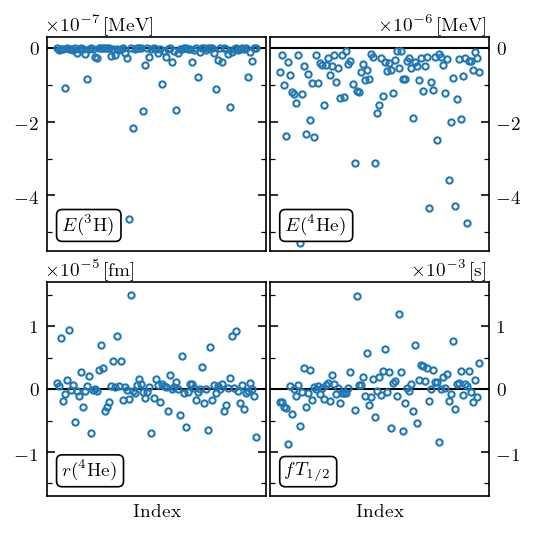

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4))
marker_size = 3
fill_style = 'none'
plot_residuals(
    H3.E_valid_true, H3.E_valid_approx,
    text=obs_names_tex_map["H3"], ax=axes[0, 0],
    markersize=marker_size, fillstyle=fill_style,
)
plot_residuals(
    He4.E_valid_true, He4.E_valid_approx,
    text=obs_names_tex_map["He4"], ax=axes[0, 1],
    markersize=marker_size, fillstyle=fill_style,
)
plot_residuals(
    He4_radius.ev_valid_true, He4_radius.ev_valid_approx,
    text=obs_names_tex_map["He4-radius"], ax=axes[1, 0],
    markersize=marker_size, fillstyle=fill_style,
)
plot_residuals(
    H3_halflife.ev_valid_true, H3_halflife.ev_valid_approx,
    text=obs_names_tex_map["H3-halflife"], ax=axes[1, 1],
    markersize=marker_size, fillstyle=fill_style,
)

axes[0, 0].yaxis.set_major_formatter(ScalarFormatterWithUnits(useOffset=False, units=obs_units["H3"]))
axes[0, 1].yaxis.set_major_formatter(ScalarFormatterWithUnits(useOffset=False, units=obs_units["He4"]))
axes[1, 0].yaxis.set_major_formatter(ScalarFormatterWithUnits(useOffset=False, units=obs_units["He4-radius"]))
axes[1, 1].yaxis.set_major_formatter(ScalarFormatterWithUnits(useOffset=False, units=obs_units["H3-halflife"]))

axes[0, 0].set_ylim(-5.5e-7, 0.3e-7)
axes[0, 1].set_ylim(-5.5e-6, 0.3e-6)
axes[1, 0].set_ylim(-1.7e-5, 1.7e-5)
axes[1, 1].set_ylim(-1.7e-3, 1.7e-3)

max_y_r = np.max(np.abs(axes[1, 0].get_ylim()))
axes[1, 0].set_ylim(-max_y_r, max_y_r)

# axes[1, 0].yaxis.set_major_locator(ticker.MaxNLocator(3))
axes[1, 0].yaxis.set_major_locator(ticker.MultipleLocator(1e-5))
# axes[1, 0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# axes[1, 1].set_ylim(-1.6e-3, 1.6e-3)

for (i, j), ax in np.ndenumerate(axes):
    if j != 0:
        ax.set_ylabel(None)
        ax.yaxis.tick_right()
    if i == 0:
        ax.set_xlabel(None)
    else:
        ax.set_xlabel("Index")
#     ax.set_yticks([])
    ax.set_xticks([])
#     ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
#     ax.yaxis.set_major_formatter(ScalarFormatterWithUnits(useOffset=False, units='s'))
    ax.ticklabel_format(style='sci', scilimits=(0, 0))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(axis='y', which='both', left=True, right=True)
    
# fig.suptitle('Validation Residuals', y=0.98)
# fig.tight_layout(h_pad=0.5, w_pad=-0.5, pad=0.4, rect=[0, 0, 1, 0.98])
fig.tight_layout(h_pad=0.5, w_pad=0.2, pad=0.1)
fig.savefig('validation_residuals.png', dpi=600)

# OLD

---

In [23]:
assert False

AssertionError: 

In [ ]:
# fig, axes = plt.subplots(len(loc_post_lecs), len(loc_post_lecs), figsize=(7, 7))
# plot_samples(
#     p_doe_nn, loc_post_lecs, cov_post_lecs,
#     names=nn_lecs_names_tex,
# #     title='EC Training Points',
# #     put_stdv_in_titles=True,
#     show_stdv_ticks=2,
#     axes=axes
# );
# plot_samples(
#     p_doe_tbf, loc_tbf_lecs, cov_tbf_lecs,
#     names=tbf_lecs_names_tex, axes=axes[1:3, -3:-1],
# #     put_stdv_in_titles=False,
#     show_stdv_ticks=2,
# );
# fig = plt.gcf()
# # fig.tight_layout()
# fig.savefig('nn_training_pts_with_ticks_big.png', transparent=False)

In [ ]:
def create_sample_params(n_lecs, n_train, n_stdv, mean, cov, seed):
    # Create random training points
    np.random.seed(seed)
    lhs_train = pyDOE.lhs(n_lecs, samples=n_train)
    p_train = lhs_train.copy()
    jj = 0
    for i in range(n_lecs):
        p_train[:, i] = adjust(lhs_train[:, i], -1, 1)

    chol = np.linalg.cholesky(cov)
    p_train = (
        mean
        + n_stdv * (chol @ p_train.T).T
    )
    return p_train

In [ ]:
p_doe = create_sample_params(
    n_lecs=n_all_lecs,
    n_train=50,
    n_stdv=3,
    mean=loc_all_lecs,
    cov=cov_all_lecs,
    seed=1
)
p_doe_nn = p_doe[:, :n_nn_lecs]
p_doe_tbf = p_doe[:, n_nn_lecs:]

In [ ]:
p_lhsnorm = lhsnorm(
    mean=loc_post_lecs,
    cov=cov_post_lecs,
    n=50,
    smooth=False,
    random_state=1,
)